In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from calendar import monthrange
from salishsea_tools import stormtools, places
from matplotlib.colors import LogNorm
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [3]:
daterange = [datetime(2015, 1, 1), datetime(2019, 1, 1)]

HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

stations = [
    {'ECname': 'Sandheads'    , 'MOADname': 'Sandheads'},
    {'ECname': 'SistersIsland', 'MOADname': 'Sisters Islet'},
    {'ECname': 'SentryShoal'  , 'MOADname': 'Sentry Shoal'},
]
for station in stations:
    for key in ['obs', 'HRDPS']:
        station[key] = {'spd': np.empty(0), 'dir': np.empty(0), 'time': np.empty(0)}

In [4]:
for year in tqdm(range(2015, 2019)):
    for month in range(1, 13):
        for station in stations:
            start = datetime(year, month, 1).strftime('%d-%b-%Y')
            end = datetime(year, month, monthrange(year, month)[1]).strftime('%d-%b-%Y')
            wspd, wdir, _, wtime, _, _ = stormtools.get_EC_observations(station['ECname'], start, end)
            station['obs']['spd'] = np.concatenate((station['obs']['spd'], wspd))
            station['obs']['dir'] = np.concatenate((station['obs']['dir'], wdir))
            station['obs']['time'] = np.concatenate((station['obs']['time'], wtime))

In [5]:
# Process wind data in ~6 month chunks
hours = int(np.diff(daterange)[0].total_seconds() / 3600)
chunk = int(hours / 8)
for hour in tqdm(range(0, hours, chunk)):

    # Date slice for current chunk
    dslc = slice(*[daterange[0] + timedelta(hours=h) for h in (hour, hour+chunk-1)])
    
    for station in stations:
    
        # Extract u and v along sections
        j, i = places.PLACES[station['MOADname']]['GEM2.5 grid ji']
        u = HRDPS.sel(time=dslc).isel(gridY=j, gridX=i).u_wind.values
        v = HRDPS.sel(time=dslc).isel(gridY=j, gridX=i).v_wind.values
        wtime = HRDPS.sel(time=dslc).time.values.astype('datetime64[s]').astype(datetime)
        
        # Wind angle
        wdir = 180 * np.arctan2(v, u) / np.pi
        wdir[wdir < 0] = wdir[wdir < 0] + 360
        wdir = wdir - 7
        
        # Update arrays
        station['HRDPS']['spd'] = np.concatenate((station['HRDPS']['spd'], np.sqrt(u**2 + v**2)))
        station['HRDPS']['dir'] = np.concatenate((station['HRDPS']['dir'], wdir - 7))
        station['HRDPS']['time'] = np.concatenate((station['HRDPS']['time'], wtime))

***

## Sandheads

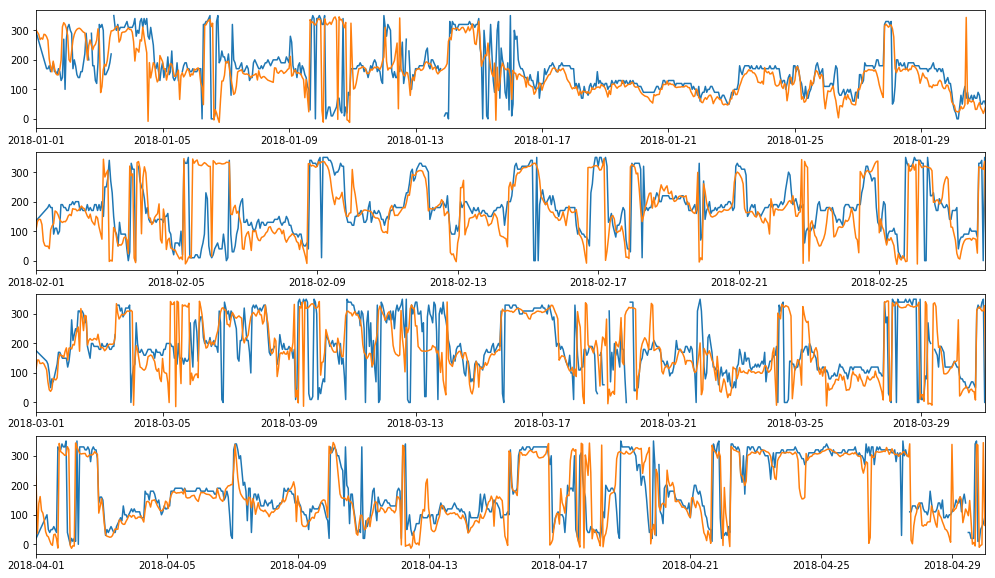

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[0]['obs']['time'], stations[0]['obs']['dir'])
    ax.plot(stations[0]['HRDPS']['time'], stations[0]['HRDPS']['dir'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])

***

## Sisters Islet

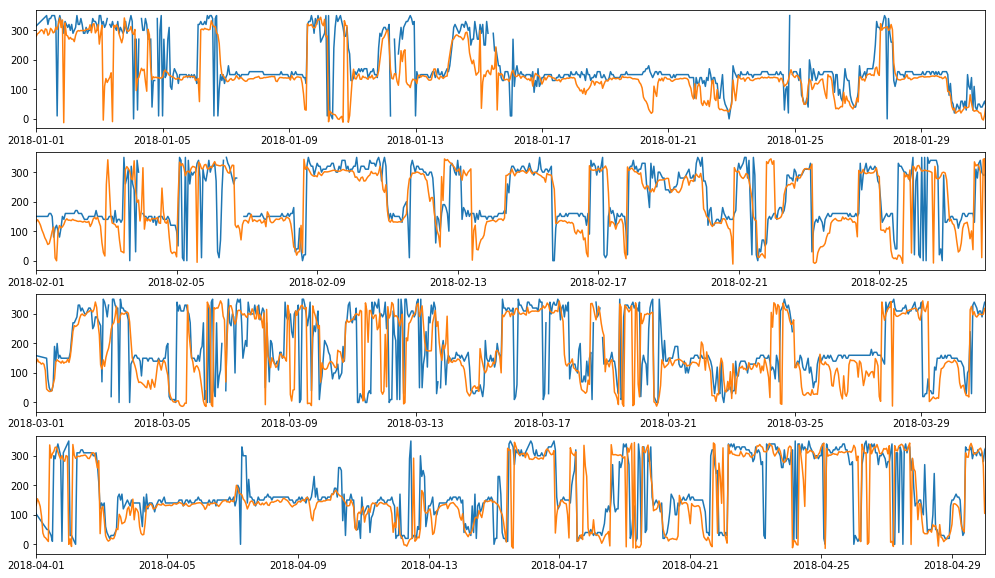

In [15]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[1]['obs']['time'], stations[1]['obs']['dir'])
    ax.plot(stations[1]['HRDPS']['time'], stations[1]['HRDPS']['dir'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])

***

## Sentry Shoal

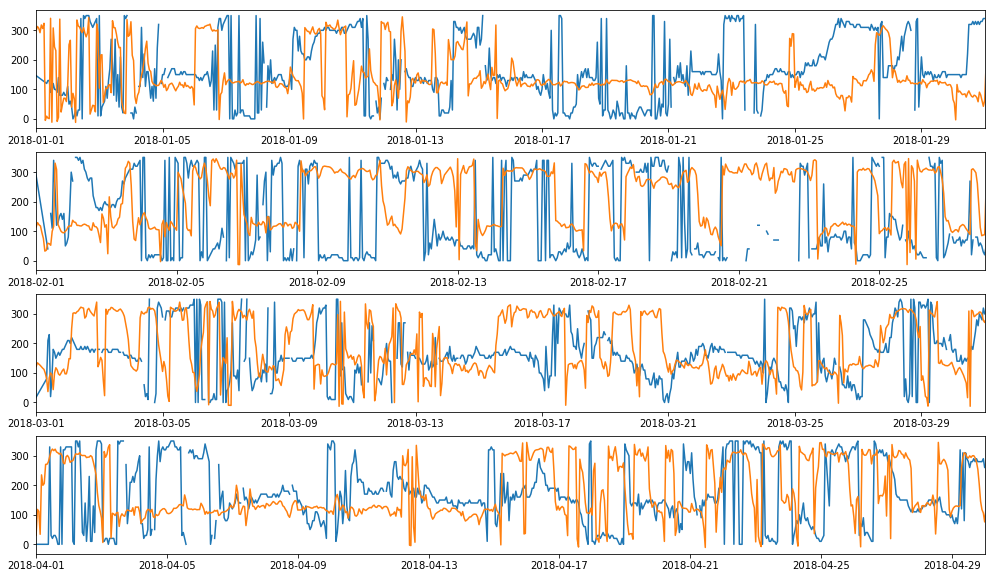

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[2]['obs']['time'], stations[2]['obs']['dir'])
    ax.plot(stations[2]['HRDPS']['time'], stations[2]['HRDPS']['dir'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])

***

## Sentry Shoal windspeed

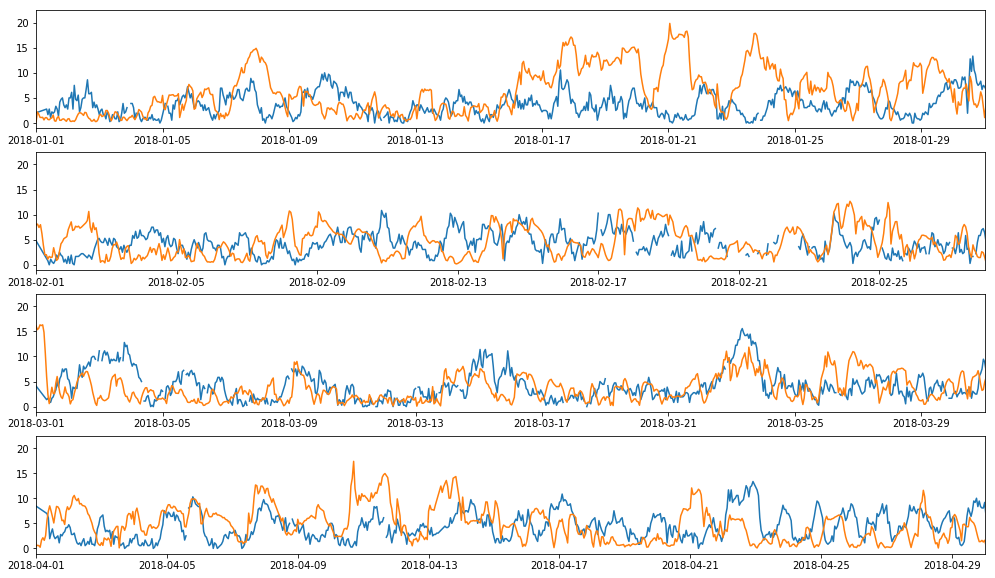

In [17]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax, month in zip(axs, range(1, 5)):
    ax.plot(stations[2]['obs']['time'], stations[2]['obs']['spd'])
    ax.plot(stations[2]['HRDPS']['time'], stations[2]['HRDPS']['spd'])
    ax.set_xlim([datetime(2018, month, 1), datetime(2018, month, monthrange(2018, month)[1])])